<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/mlp/mlp_imdb_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP applied to IMDB movie reviews (binary sentiment analysis) <a class="anchor" id="imdb-keras-mlp"></a>

We use the IMDB movie review dataset, where the task is to classify the sentiment of the review as positive or negative. We use the preprocessed version of the dataset from
https://www.tensorflow.org/datasets

In [1]:

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. DNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

In [2]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
import sklearn
from time import time

In [5]:
#We can also use the version that ships with keras (this does not require an additional download)
imdb = keras.datasets.imdb

vocab_size = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)
print(np.shape(train_data)) # (25000)
print(train_data[0])
# [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941...]

word_index = imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

for i in range(2):
  print('example {}, label {}'.format(i, train_labels[i]))
  print(decode_review(train_data[i]))

(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
example 0, label 1
<START> this film was just brill

In [6]:
# Keras padding - every example in the dataset has fixed length

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, value=word_index["<PAD>"], padding='post', maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, value=word_index["<PAD>"], padding='post', maxlen=256)

print(train_data.shape)
print(train_data[0])

(25000, 256)
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   2

In [7]:

embed_size = 16
def make_model(embed_size):
  tf.random.set_seed(42)
  np.random.seed(42)
  model = keras.Sequential()
  model.add(keras.layers.Embedding(vocab_size, embed_size))
  model.add(keras.layers.GlobalAveragePooling1D())
  model.add(keras.layers.Dense(16, activation=tf.nn.relu))
  model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
  return model

model = make_model(embed_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [8]:
x_val = train_data[:10000]
x_train = train_data[10000:]

y_val = train_labels[:10000]
y_train = train_labels[10000:]

history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/50
30/30 [==============================] - 0s 17ms/step - loss: 0.6917 - acc: 0.5245 - val_loss: 0.6891 - val_acc: 0.5353
Epoch 2/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6844 - acc: 0.6204 - val_loss: 0.6796 - val_acc: 0.7214
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6700 - acc: 0.7399 - val_loss: 0.6630 - val_acc: 0.6894
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6465 - acc: 0.7456 - val_loss: 0.6363 - val_acc: 0.7644
Epoch 5/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6129 - acc: 0.7871 - val_loss: 0.6016 - val_acc: 0.7877
Epoch 6/50
30/30 [==============================] - 0s 13ms/step - loss: 0.5714 - acc: 0.8108 - val_loss: 0.5612 - val_acc: 0.8076
Epoch 7/50
30/30 [==============================] - 0s 13ms/step - loss: 0.5255 - acc: 0.8345 - val_loss: 0.5191 - val_acc: 0.8228
Epoch 8/50
30/30 [==============================] - 0s 13ms/step - loss: 0.4798 - a

In [9]:
history_dict = history.history
print(history_dict.keys())

results = model.evaluate(test_data, test_labels)
print(results)

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
782/782 [==============================] - 1s 2ms/step - loss: 0.3712 - acc: 0.8652
[0.37122461199760437, 0.8651999831199646]


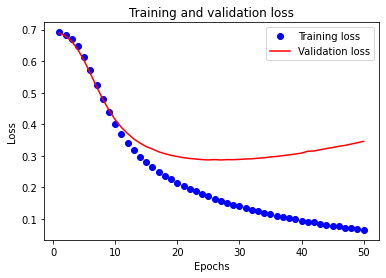

In [10]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
fig, ax = plt.subplots()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'r-', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#save_fig("imdb-loss.pdf")
plt.show()


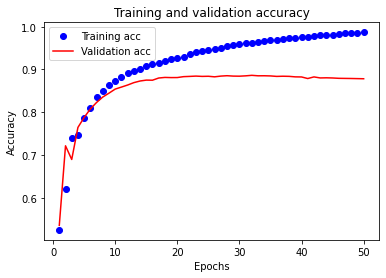

In [11]:
fig, ax = plt.subplots()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#save_fig("imdb-acc.pdf")
plt.show()


In [12]:
# Now turn on early stopping
# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
    
callbacks = [PrintDot(),
             keras.callbacks.EarlyStopping(monitor='val_acc', patience=2),
             keras.callbacks.ModelCheckpoint(filepath='imdb_keras_best_model.ckpt',
                                             monitor='val_acc', save_best_only=True)]


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


..INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


..INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


.INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


INFO:tensorflow:Assets written to: imdb_keras_best_model.ckpt/assets


..

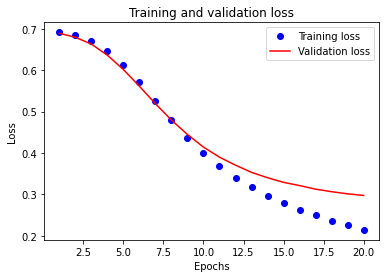

In [13]:
# Reset parameters to a new random state
model = make_model(embed_size)
history = model.fit(
    x_train, y_train, epochs=50, batch_size=512, 
    validation_data=(x_val, y_val), verbose=0, callbacks=callbacks)

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
fig, ax = plt.subplots()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'r-', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#save_fig("imdb-loss-early-stop.pdf")
plt.show()
